# Naive-Bayes and Bayesian Linear Regression
## ASI Assessed Exercise 2017

Giulio Collura

In this homework the MNIST and CIFAR10 datasets available to download from:
* http://yann.lecun.com/exdb/mnist/
* https://www.cs.toronto.edu/~kriz/cifar.html

Here below, there are some function to ease the loading of the dataset, plot some special graphs and calculate means and variances of the datasets.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.rcParams['font.family'] = 'Fira Sans'
np.seterr(divide='ignore', invalid='ignore')


def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def read_mnist(dataset='training', path='.'):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    From: https://gist.github.com/akesling/5358964
    """
    import os, struct

    if dataset is 'training':
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is 'testing':
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    return list(zip(lbl, img))


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', ax=None, cmap=plt.cm.Blues):
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    else:
        fig = ax.get_figure()
    image = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    plt.colorbar(mappable=image, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    ax.get_default_bbox_extra_artists
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    return ax

def prior_means_vars(train_data, N, use_variance=False):
    """
    @return prior p(t_new = k)
    @return means for each class
    @return variances for each class
    """
    p = np.zeros(N)
    m = np.zeros(N, dtype=object)
    v = np.zeros(N, dtype=object)
    for i in np.arange(N):
        p[i] = np.sum([x[0] == i for x in train_data]) / len(train_data)
        m[i] = np.mean([x[1] for x in train_data if x[0] == i], axis=0)
        if use_variance:
            v[i] = np.var([x[1] for x in train_data if x[0] == i], axis=0)
        else:
            v[i] = np.std([x[1] for x in train_data if x[0] == i], axis=0, ddof=1)
    return p, m, v

## Dataset Loading

### MNIST

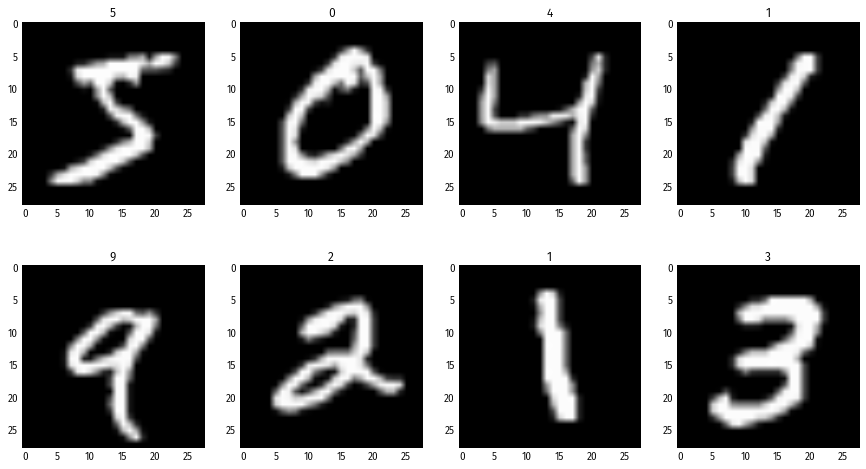

In [2]:
mnist_train = read_mnist('training')
mnist_test = read_mnist('testing')

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for ax, (label, image) in zip(axes.flat, mnist_train[:8]):
    ax.imshow(image, cmap='gray')
    ax.set_title(label)
plt.show()

### CIFAR-10

CIFAR-10 dataset is a bit more complex than MNIST dataset. Each image array consists of $3 \cdot 32 \cdot 32$ integers with domain range $[0, 255]$, where $3$ is the number of color channels, RGB.

Categories: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


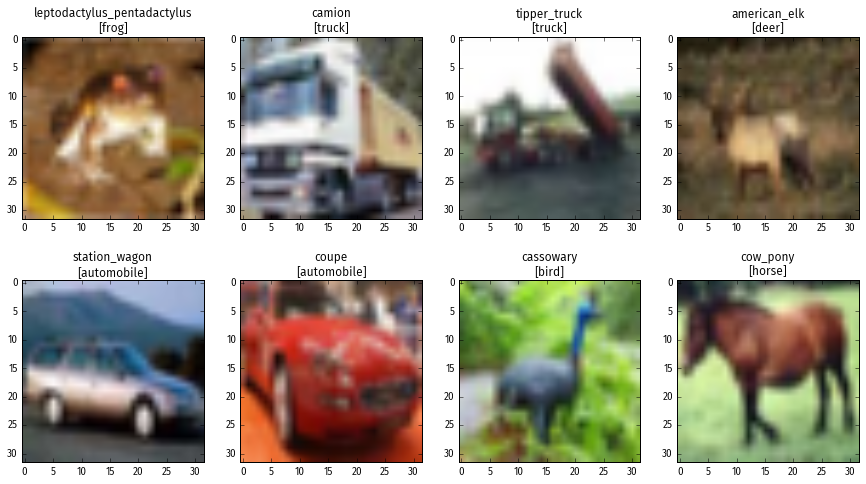

In [4]:
cifar_data_1 = unpickle('cifar-10-batches-py/data_batch_1')
cifar_test_data = unpickle('cifar-10-batches-py/test_batch')
cifar_categories = unpickle('cifar-10-batches-py/batches.meta')[b'label_names']

print('Categories:', [cat.decode() for cat in cifar_categories])

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for ax, data, cat_id, filename in zip(axes.flat,
                                      cifar_data_1[b'data'][:8],
                                      cifar_data_1[b'labels'][:8],
                                      cifar_data_1[b'filenames'][:8]):
    ax.set_title('%s\n[%s]' % (filename.decode()[:-13], cifar_categories[cat_id].decode()))
    ax.imshow(data.reshape(3, 32, 32).swapaxes(0, 2).swapaxes(0, 1))
plt.show()


cifar_train = [(label, x) for label, x in zip(cifar_data_1[b'labels'], cifar_data_1[b'data'])]
cifar_test = [(label, x) for label, x in zip(cifar_test_data[b'labels'], cifar_test_data[b'data'])]

In square brackets, the name of the category the image belongs to.

## Dataset analysis

First, we proceed by analyzing the datasets. We consider the number of classes and the number of train data per class. Then, we calculate and display the mean values and the stardard deviation for each available class of our datasets, in order to better understand the shape of our data.

### MNIST

Data distribution analysis

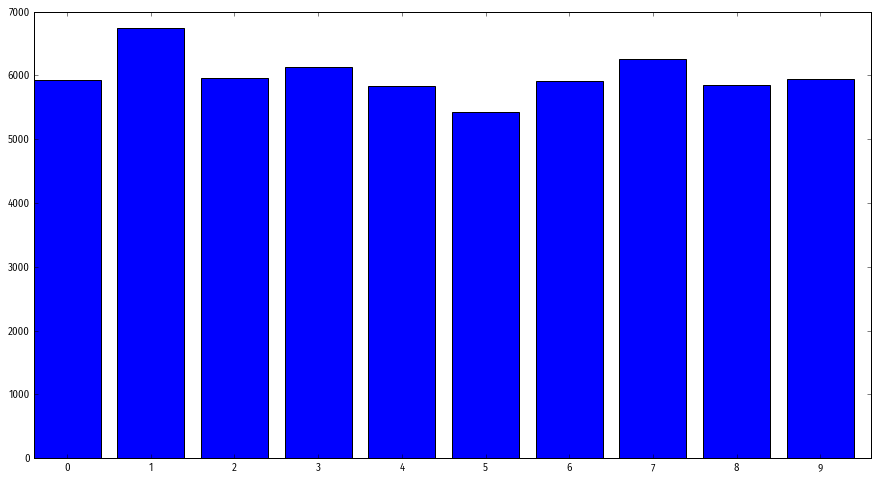

In [4]:
mnist_labels = [x[0] for x in mnist_train]
mnist_labels_hist = np.histogram(mnist_labels, bins=range(11))

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(mnist_labels_hist[1][:-1], mnist_labels_hist[0])
ax.set_xticks(mnist_labels_hist[1][:-1] + 0.4)
ax.set_xticklabels(np.arange(0, 10))
plt.show()

<div class='alert alert-success'>
We notice that the train data is not homogenously distributed across all the classes. In particular, the class `1` and `5` are respectively more populated and less populated. We might expect more classification errors between these two classes.
</div>

Let's calculate the mean and standard deviation values for each class.

In [5]:
N = 10
mnist_prior, mnist_means, mnist_vars = prior_means_vars(mnist_train, N)

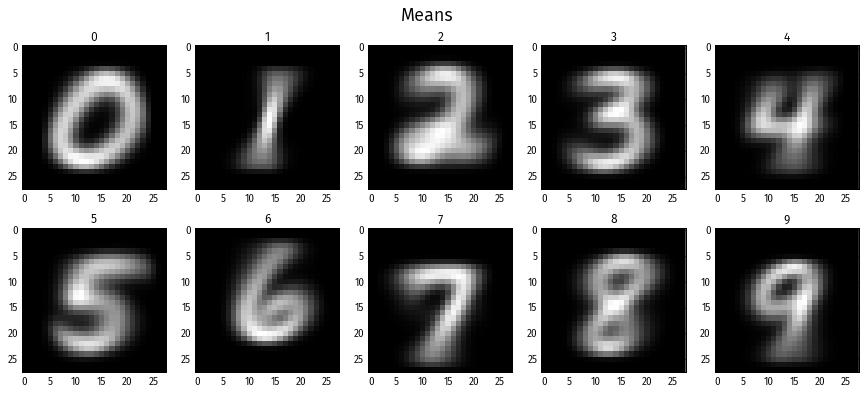

In [105]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Means', fontsize=18)
for ax, label, image in zip(axes.flat, range(10), mnist_means):
    ax.imshow(image, cmap='gray', interpolation='none')
    ax.set_title(label)
plt.show()

<div class='alert alert-success'>
The *average* MNIST digit is still very distinguishable, this may indicate that most of the digits look like each other.
</div>

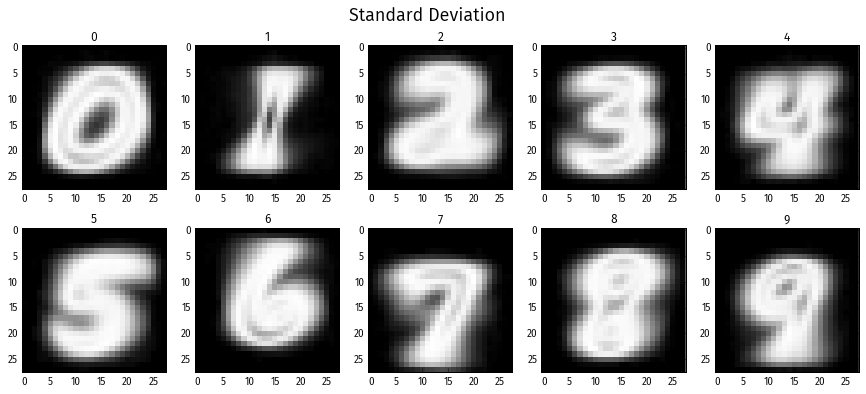

In [108]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Standard Deviation', fontsize=18)
for ax, label, image in zip(axes.flat, range(10), mnist_vars):
    ax.imshow(image, cmap='gray', interpolation='none')
    ax.set_title(label)
plt.show()

<div class='alert alert-success'>
The Standard Deviation shows where the digits in each class differs the most. These are usually on the borders of the average digit.
</div>

We try to see what happens if we discrete the data, which means having only $0$ and $1$. To achieve this result, we approximate values below $128$ as $0$ and values above or equal to $128$ as 1.

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 

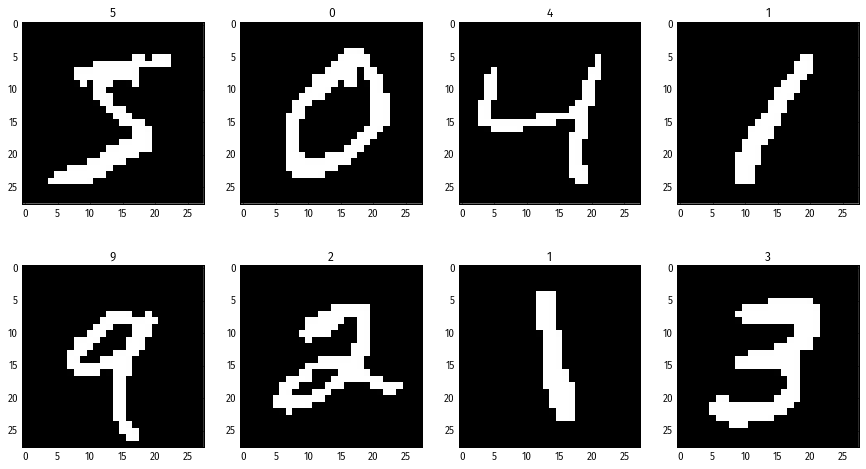

In [6]:
mnist_train_discrete = [(label, image // 128) for label, image in mnist_train]
mnist_test_discrete = [(label, image // 128) for label, image in mnist_test]
mnist_discrete_prior, mnist_discrete_means, mnist_discrete_vars = prior_means_vars(mnist_train_discrete, N)

print(mnist_train_discrete[0][1])

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for ax, (label, image) in zip(axes.flat, mnist_train_discrete[:8]):
    ax.imshow(image, cmap='gray', interpolation='none')
    ax.set_title(label)
plt.show()

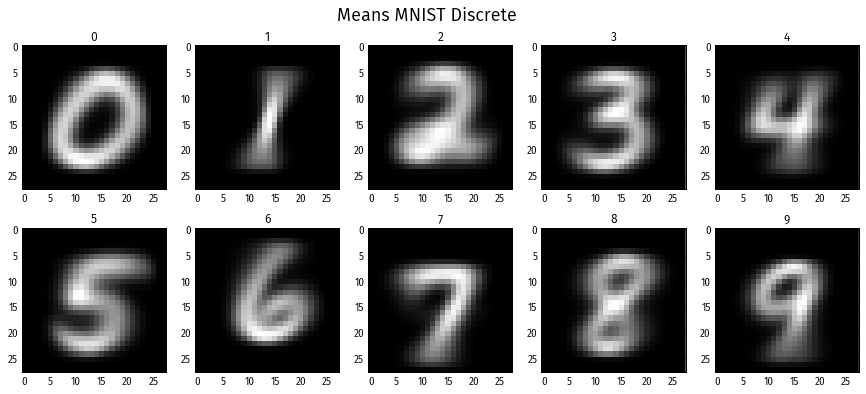

In [113]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Means MNIST Discrete', fontsize=18)
for ax, label, image in zip(axes.flat, range(10), mnist_discrete_means):
    ax.imshow(image, cmap='gray', interpolation='none')
    ax.set_title(label)
plt.show()

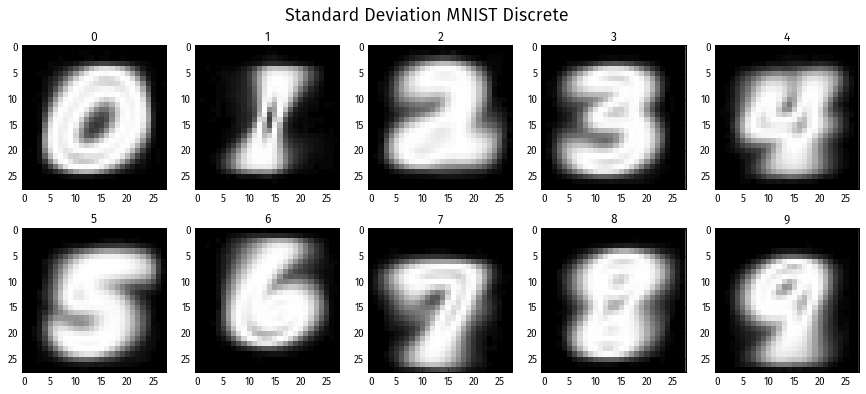

In [114]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Standard Deviation MNIST Discrete', fontsize=18)
for ax, label, image in zip(axes.flat, range(10), mnist_discrete_vars):
    ax.imshow(image, cmap='gray', interpolation='none')
    ax.set_title(label)
plt.show()

<div class='alert alert-success'>
The result doesn't differ much from a visual point of view.
</div>

### CIFAR-10

We will only consider (for easing the computation) one set of training data from the CIFAR-10 dataset.

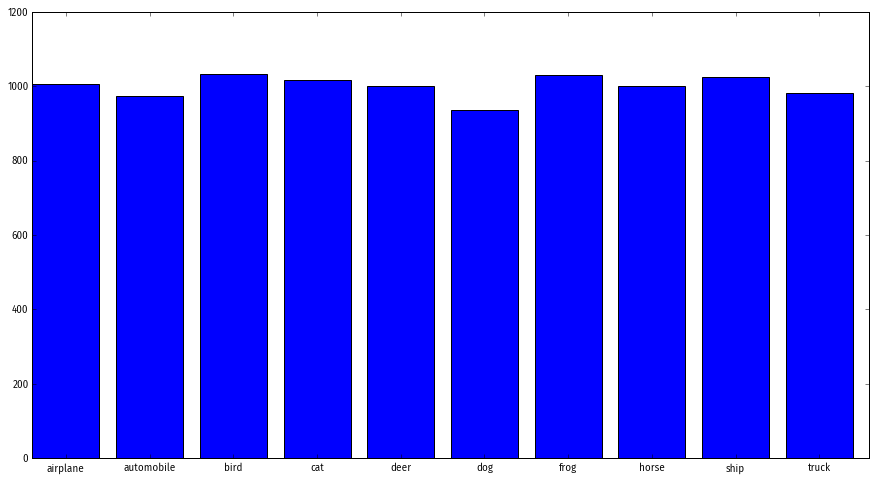

In [10]:
cifar_labels = cifar_data_1[b'labels']
cifar_labels_hist = np.histogram(cifar_labels, bins=range(len(cifar_categories) + 1))

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(cifar_labels_hist[1][:-1], cifar_labels_hist[0])
ax.set_xticks(cifar_labels_hist[1][:-1] + 0.4)
ax.set_xticklabels([cifar_categories[cat_id].decode() for cat_id in cifar_labels_hist[1][:-1]])
plt.show()

<div class='alert alert-success'>
Similarly to what has happened with MNIST dataset, the numbers of elements within each class is different. However we have around 1000 representations for each class.
</div>

In [7]:
N = len(cifar_categories)

cifar_prior, cifar_means, cifar_vars = prior_means_vars(cifar_train, N)

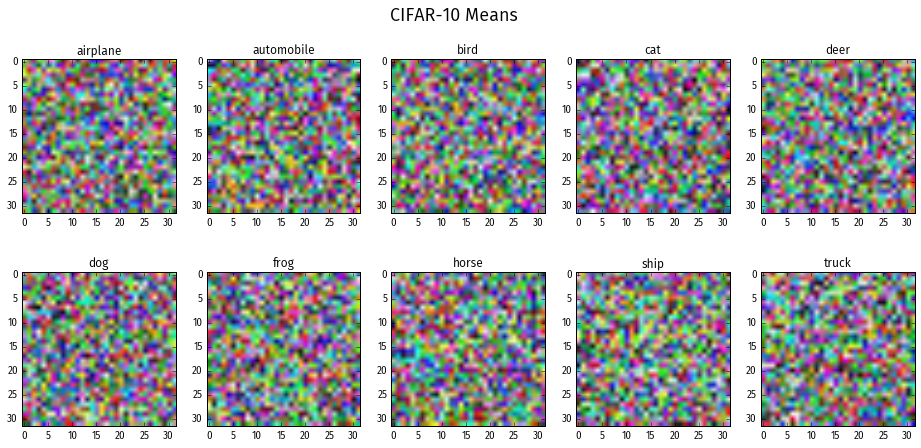

In [135]:
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
fig.suptitle('CIFAR-10 Means', fontsize=18)
for ax, mean, category in zip(axes.flat, cifar_means, cifar_categories):
    ax.set_title(category.decode())
    ax.imshow(mean.reshape(3, 32, 32).swapaxes(0, 2).swapaxes(0, 1), interpolation=None)
plt.show()

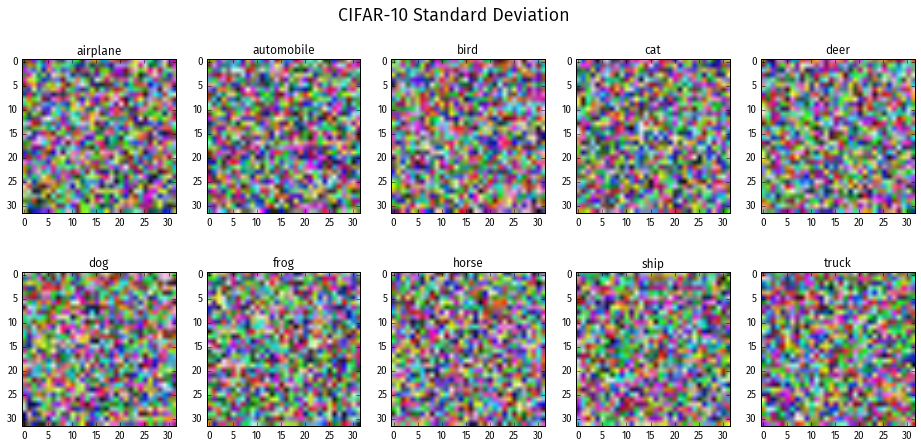

In [136]:
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
fig.suptitle('CIFAR-10 Standard Deviation', fontsize=18)
for ax, var, category in zip(axes.flat, cifar_vars, cifar_categories):
    ax.set_title(category.decode())
    ax.imshow(var.reshape(3, 32, 32).swapaxes(0, 2).swapaxes(0, 1))
plt.show()

<div class='alert alert-success'>
Both the means and the standard deviations of each classes is just random values. This might be due to some approximation errors during computations in the numpy library.
</div>

#### CIFAR-10 Data Normalization

Since we cannot grasp any conclusion on the data displayed above, we try the approach of data normalization. We scale down che domain of the images bits from $[0, 256)$ to $[0, 1.0]$.

In [137]:
cifar_train_norm = [(label, x / 255) for label, x in zip(cifar_data_1[b'labels'], cifar_data_1[b'data'])]
cifar_test_norm = [(label, x / 255) for label, x in zip(cifar_test_data[b'labels'], cifar_test_data[b'data'])]

N = len(cifar_categories)

cifar_norm_prior, cifar_norm_means, cifar_norm_vars = prior_means_vars(cifar_train_norm, N)

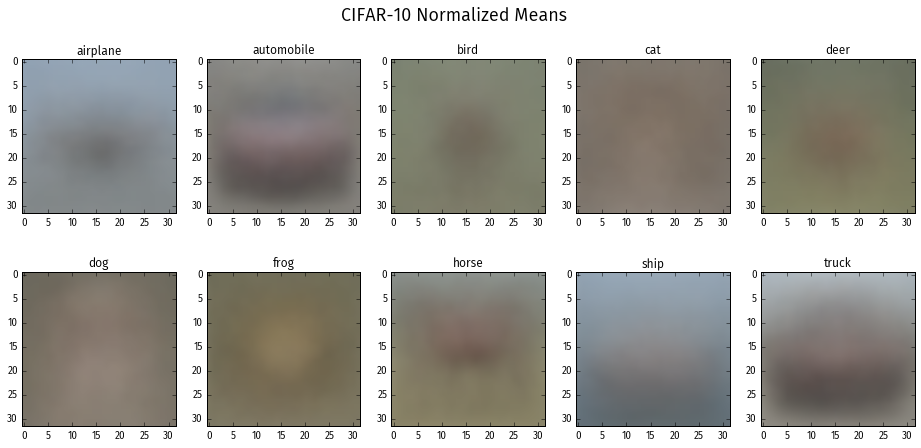

In [138]:
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
fig.suptitle('CIFAR-10 Normalized Means', fontsize=18)
for ax, mean, category in zip(axes.flat, cifar_norm_means, cifar_categories):
    ax.set_title(category.decode())
    ax.imshow(mean.reshape(3, 32, 32).swapaxes(0, 2).swapaxes(0, 1), interpolation=None)
plt.show()

<div class='alert alert-success'>
The results obtained here are somewhat a bit clearer than before. In some cases, especially with `airplane`, `automobile` and `horse` classes we might start guessing they look like a representation of their respective categories.
</div>

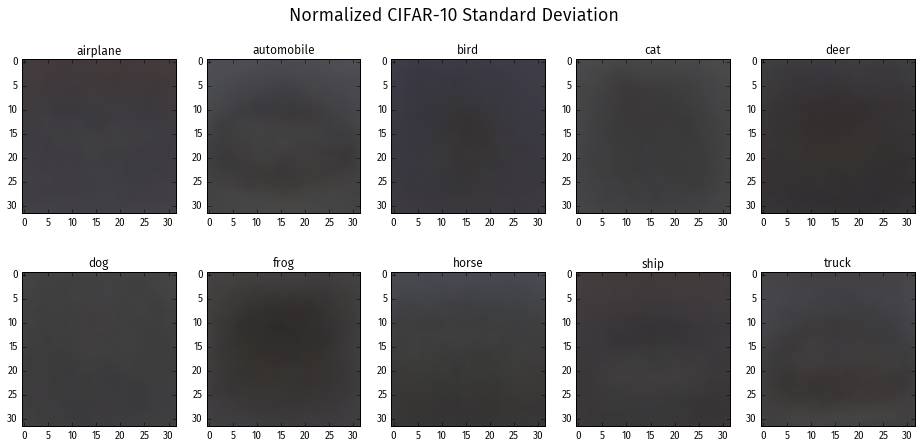

In [140]:
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
fig.suptitle('Normalized CIFAR-10 Standard Deviation', fontsize=18)
for ax, var, category in zip(axes.flat, cifar_norm_vars, cifar_categories):
    ax.set_title(category.decode())
    ax.imshow(var.reshape(3, 32, 32).swapaxes(0, 2).swapaxes(0, 1))
plt.show()

<div class='alert alert-success'>
On the other hand, the standard deviation of the Normalised CIFAR-10 dataset does not give us much information from a graphical point of view. 
</div>

## Naive-Bayes classifier

### Code implementation

This is the general formula behind the reasoning of a Naive-Bayes classifier.

\begin{equation}
    P(t_{new} = k | x_{new}, \mathbf{X}, \mathbf{t}) = \frac{p(x_{new}|t_{new} = k, \mathbf{X}, \mathbf{t})P(t_{new} = k)}{\sum_{j}p(x_{new}|t_{new} = j, \mathbf{X}, \mathbf{t})P(t_{new} = j)}
\end{equation}

We proceed to implement the methods our algorithm will use to generate prediction based on the training data.

In [176]:
def log_gaussian(x, m, v):
    """
    Optimized Gaussian function calculation at a given point, given mean and variance
    """
    return -0.5 * np.log(2 * np.pi * v) + (-(x - m)**2 / (2 * v))

def probability(x, mean, variance):
    """
    Calculate the probability using np.log to ease calculations
    """
    return np.sum([log_gaussian(x_i, m, v if v > 0 else 1e-10)
                   for x_i, m, v in zip(x, mean, variance)])

def likelihood(x, means, variances):
    return np.array([probability(x, mean, var) for mean, var in zip(means, variances)])

def predictions(x, prior, means, variances):
    pred = likelihood(x, means, variances) * prior
    return pred / pred.sum()

def predict(x, prior, means, variances):
    return np.argmin(predictions(x, prior, means, variances))

def accuracy(prediction):
    return np.sum([p[0] == p[1] for p in prediction]) / len(prediction)

### MNIST - Data preparation

We calculate $\mu$, $\sigma^2$ and $p(t = k)$ for all possible classes.

In [26]:
mnist_train_norm = [(label, x.flatten()) for label, x in mnist_train]
mnist_test_norm = [(label, x.flatten()) for label, x in mnist_test]

N = 10 # number of digits, this value can be hard-coded

mnist_prior, mnist_means, mnist_vars = prior_means_vars(mnist_train_norm, N)

### MNIST - Prediction through Naive-Bayes classifier

In [28]:
mnist_pred = np.array([(t_new, predict(x_new, mnist_prior, mnist_means, mnist_vars))
        for t_new, x_new in mnist_test_norm])
print('Accuracy Naive-Bayes: %.2f%%' % (accuracy(mnist_pred) * 100))

Accuracy Naive-Bayes: 82.85%


Confusion matrix, without normalization
[[882   0   4   1   1  69  11   1  11   0]
 [  0 939  17   1   1  81   6   0  90   0]
 [ 14   1 882  10  11  21  23   6  62   2]
 [  6   0  49 765   1 115   7   9  43  15]
 [  4   0  13   2 758  46  14   3  33 109]
 [ 13   0   7  25   8 798  12   2  19   8]
 [ 16   1  22   0   5  61 849   0   4   0]
 [  1   5  17   2  22  19   1 797  53 111]
 [  7   0  14  16   7 125   5   3 775  22]
 [  5   0   5   6  69  34   0  11  39 840]]


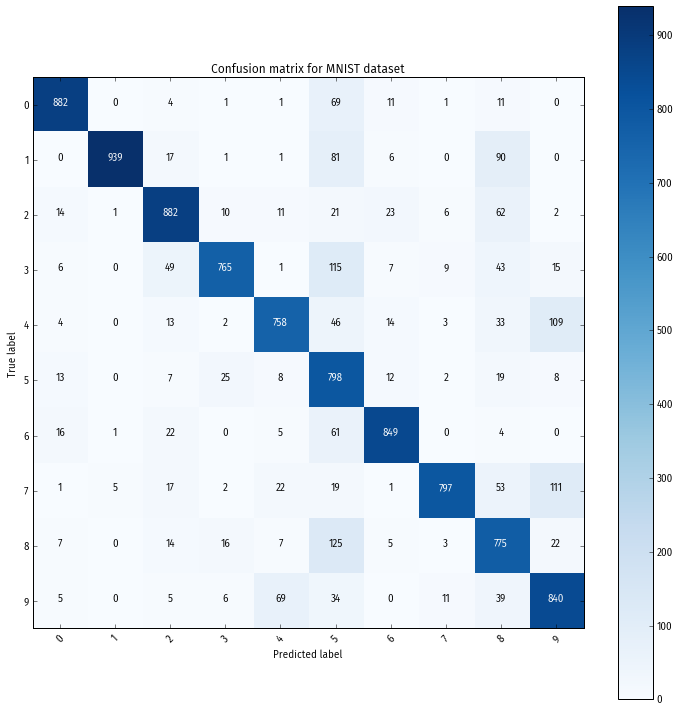

In [34]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(mnist_pred[:,0], mnist_pred[:,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=[str(i) for i in range(N)], title='Confusion matrix for MNIST dataset')
plt.show()

<div class='alert alert-success'>
As we guessed above, we have more mispredictions on the class 5, since we have less train data on this digit. Moreover, the digit 5 is usually the most complex digit to draw free-handed and it might resemble other numbers pretty easily if not drawn with attention.
</div>

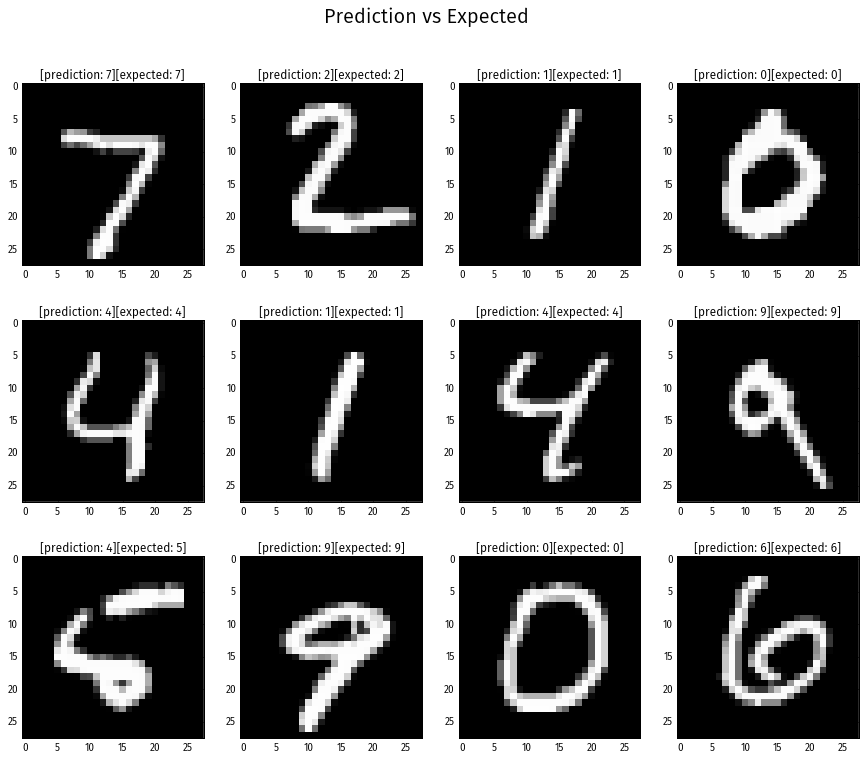

In [40]:
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
fig.suptitle('Prediction vs Expected', fontsize=20)
for ax, (_, image), (expected, prediction) in zip(axes.flat, mnist_test[:12], mnist_pred[:12]):
    ax.set_title('[prediction: %s][expected: %s]' % (prediction, expected))
    ax.imshow(image.reshape(28, 28), cmap='gray', interpolation='none')
plt.show()

As we can see in the figure above, the mispredicted 5, which has been interpreted as 4, might not look a 5 for most people, since the circle on the bottom part is almost close to a 6 drawing.

### MNIST - Data discretization and prediction

Here, we try to predict labels for our test digits by changing the domain of each pixel from $[0, 255]$ to $[0, 1]$.

In [152]:
mnist_train_discrete = [(label, (x // 128).flatten()) for label, x in mnist_train]
mnist_test_discrete = [(label, (x // 128).flatten()) for label, x in mnist_test]

N = 10

mnist_discrete_prior, mnist_discrete_means, mnist_discrete_vars = prior_means_vars(mnist_train_discrete, N)

In [153]:
mnist_discrete_pred = np.array([(t_new, predict(x_new, mnist_discrete_prior, mnist_discrete_means, mnist_discrete_vars))
        for t_new, x_new in mnist_test_discrete])
print('Accuracy Naive-Bayes (with discretization): %.2f%%' % (accuracy(mnist_discrete_pred) * 100))

Accuracy Naive-Bayes (with discretization): 22.36%


Confusion matrix, without normalization
[[611 214  33   0   0  93   1   1   1  26]
 [  1 572   3   0   0 558   0   0   0   1]
 [155 588   5   3   0 101 101   6   4  69]
 [110 579  68  41   0 118   7  17   4  66]
 [ 79 259  56   1   0 249  13  18  10 297]
 [ 67 400 151   2   0  27   5   1  79 160]
 [ 55 480   1   0   0   4 411   0   1   6]
 [  3 267   4   0   0  18   2  66   0 668]
 [ 29 466  99   0   0 255   6   0  33  86]
 [  4 469  25   1   0  40   0   0   0 470]]


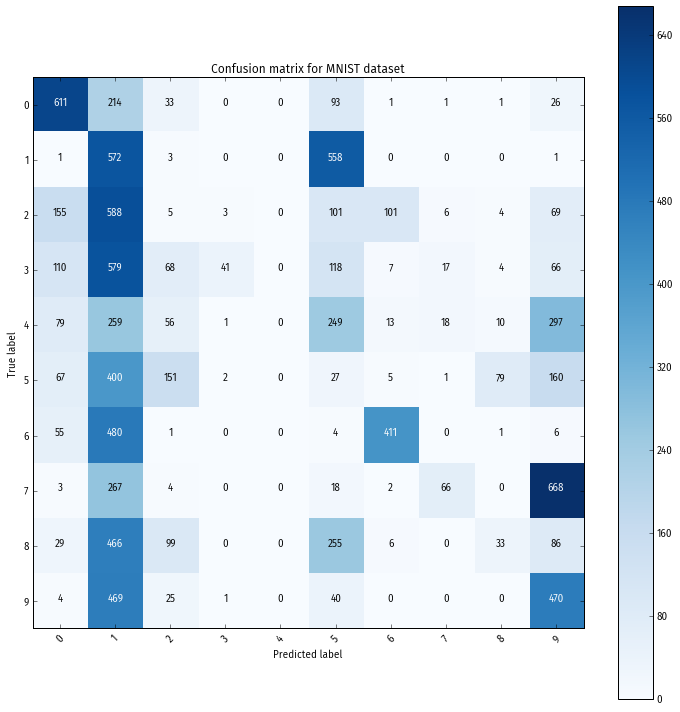

In [154]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(mnist_discrete_pred[:,0], mnist_discrete_pred[:,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=[str(i) for i in range(N)], title='Confusion matrix for MNIST dataset')
plt.show()

<div class='alert alert-success'>
Data discretization and normalized doesn't lead us to better results. We might try to increase the difference between the positive value and zeros by multiplying by 255.
</div>

In [155]:
mnist_train_discrete = [(label, (x // 128).flatten() * 255) for label, x in mnist_train]
mnist_test_discrete = [(label, (x // 128).flatten() * 255) for label, x in mnist_test]

N = 10

mnist_discrete_prior, mnist_discrete_means, mnist_discrete_vars = prior_means_vars(mnist_train_discrete, N)

In [156]:
mnist_discrete_pred = np.array([(t_new, predict(x_new, mnist_prior_discrete, mnist_means_discrete, mnist_vars_discrete))
                                for t_new, x_new in mnist_test_discrete])
print('Accuracy Naive-Bayes (with discretization): %.2f%%' % (accuracy(mnist_discrete_pred) * 100))

Accuracy Naive-Bayes (with discretization): 82.36%


Confusion matrix, without normalization
[[883   0   5   1   1  66   9   1  14   0]
 [  0 942  13   0   0  69   5   0 106   0]
 [ 16   0 876  13   9  19  23   4  71   1]
 [  7   0  52 765   3 106   6   9  47  15]
 [  6   0  10   1 735  57  15   3  36 119]
 [ 12   0   5  26   8 792  14   2  24   9]
 [ 19   1  26   0   5  64 839   0   4   0]
 [  0   1  16   7  24  19   1 769  65 126]
 [  7   1  15  16   6 109   5   3 791  21]
 [  5   0   4   6  60  35   0  10  45 844]]


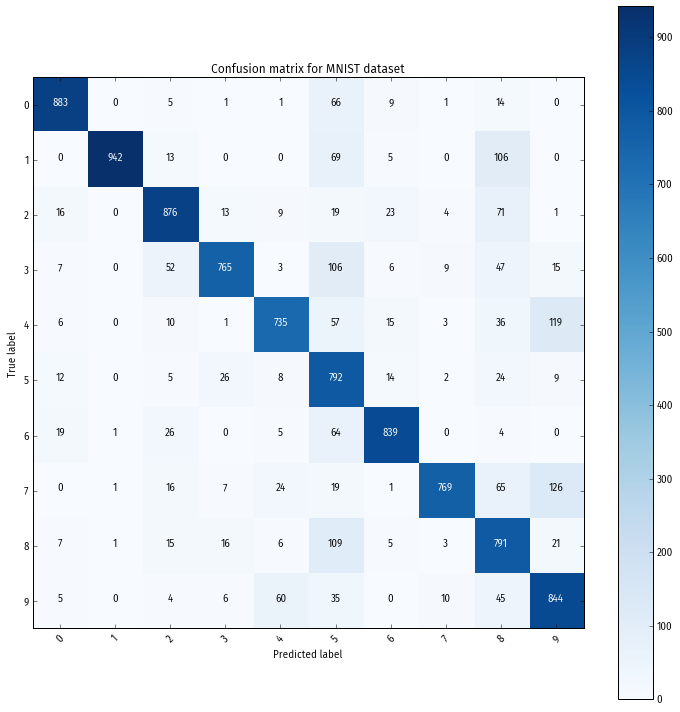

In [157]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(mnist_discrete_pred[:,0], mnist_discrete_pred[:,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=[str(i) for i in range(N)], title='Confusion matrix for MNIST dataset')
plt.show()

<div class='alert alert-success'>
Denormalizing data, while maintaining the discretization (only 0 or 255 values), leads us to results similar to non-normalized data. Still, we are not improving our predictions.
</div>

### MNIST - Random classifier

We experiment by testing a *random classifier*, which consists of generating a random prediction for each test digit. We might expect, if the random generator in not biased towards any particural digit and every label has a probability of $\frac{1}{10}$, to have around 10% of accuracy on our predictor.

Accuracy Random Classifier: 9.64%
Confusion matrix, without normalization
[[ 99 107  88  99 109 107  93  78  98 102]
 [139 120 109 114 103 100 125 113  96 116]
 [ 99 108 103 110 108 119  95 103  86 101]
 [113 109  96  84  96 101 110 100 113  88]
 [111  85 115  84  84 109  90 100 107  97]
 [106  85  83  97  94  76  93  81  85  92]
 [ 71 109  99 102  85 107  98 108  91  88]
 [100 101 106 113 107  94 100 108 105  94]
 [ 89  98 107  99  88  92 107  91 108  95]
 [ 92  94  97 102 114 107 101 117 101  84]]


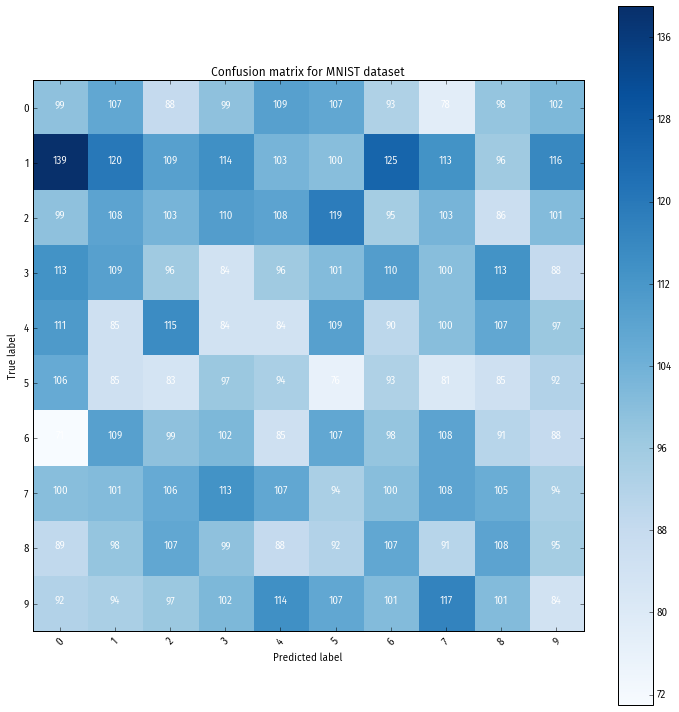

In [52]:
mnist_random_pred = np.array([(t_new, np.random.randint(0, N)) for t_new, x_new in mnist_test])
print('Accuracy Random Classifier: %.2f%%' % (accuracy(mnist_random_pred) * 100))

# Compute confusion matrix
cnf_matrix = confusion_matrix(mnist_random_pred[:,0], mnist_random_pred[:,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=[str(i) for i in range(N)], title='Confusion matrix for MNIST dataset')
plt.show()

<div class='alert alert-success'>
As we might have guessed since the beginning, randomly predicting labels leads us to an accurancy of more or less 10%. At this point, predicting always the same number (eg. 0) leads us to have the same accuracy.
</div>

### CIFAR-10 - Data preparation

In [181]:
cifar_train_norm = [(label, x) for label, x in zip(cifar_data_1[b'labels'], cifar_data_1[b'data'])]
cifar_test_norm = [(label, x) for label, x in zip(cifar_test_data[b'labels'], cifar_test_data[b'data'])]

N = len(cifar_categories)

cifar_prior, cifar_means, cifar_vars = prior_means_vars(cifar_train_norm, N)

In [182]:
cifar_pred = np.array([(t_new, predict(x_new, cifar_prior, cifar_means, cifar_vars))
                       for t_new, x_new in cifar_test_norm])
print('Accuracy Naive-Bayes: %.2f%%' % (accuracy(cifar_pred) * 100))

Accuracy Naive-Bayes: 25.43%


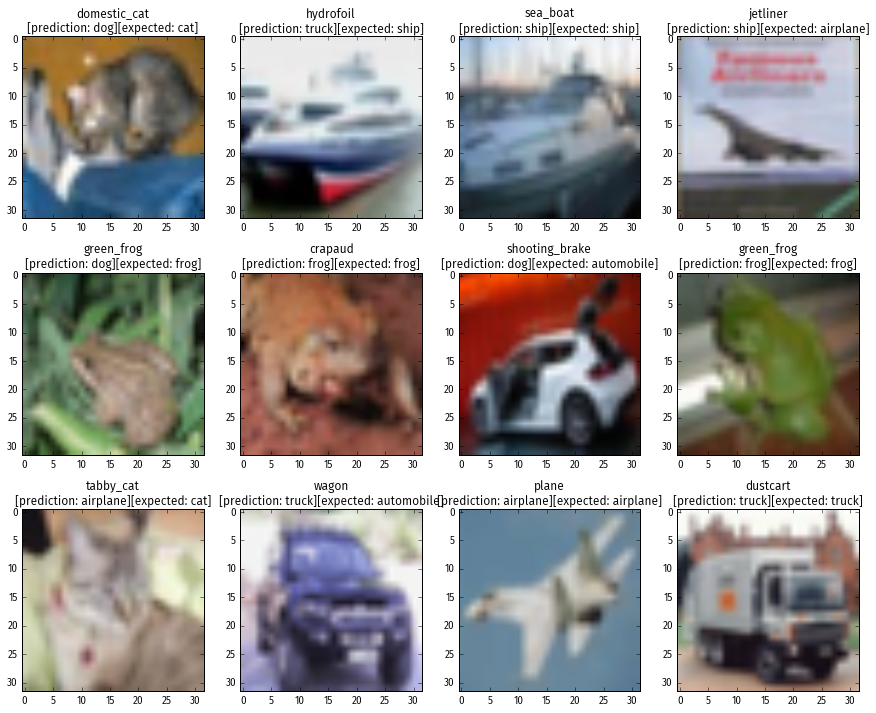

In [183]:
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
for ax, data, filename, (expected, prediction) in zip(axes.flat, cifar_test_data[b'data'][:12],
                                                      cifar_test_data[b'filenames'][:12], cifar_pred[:12]):
    ax.set_title('%s\n[prediction: %s][expected: %s]' % (filename.decode()[:-13], 
                                                         cifar_categories[prediction].decode(), 
                                                         cifar_categories[expected].decode()))
    ax.imshow(data.reshape(3, 32, 32).swapaxes(0, 2).swapaxes(0, 1))
plt.show()

Confusion matrix, without normalization
[[550 147   0   2   0 125   9   9  60  98]
 [136 428   0   1   0 208  20  14  15 178]
 [258 152  13  13   3 309 122  83   6  41]
 [161 165   1  19   1 476  68  35   2  72]
 [103 137   6   8  11 403 199  73   7  53]
 [155 126   1   7   0 557  42  46  13  53]
 [107 157   1  19   1 346 257  60   1  51]
 [141 149   0   6   1 348  31 130  12 182]
 [281 184   1   0   0 168   4   4 168 190]
 [136 307   0   2   0  94  13   5  33 410]]


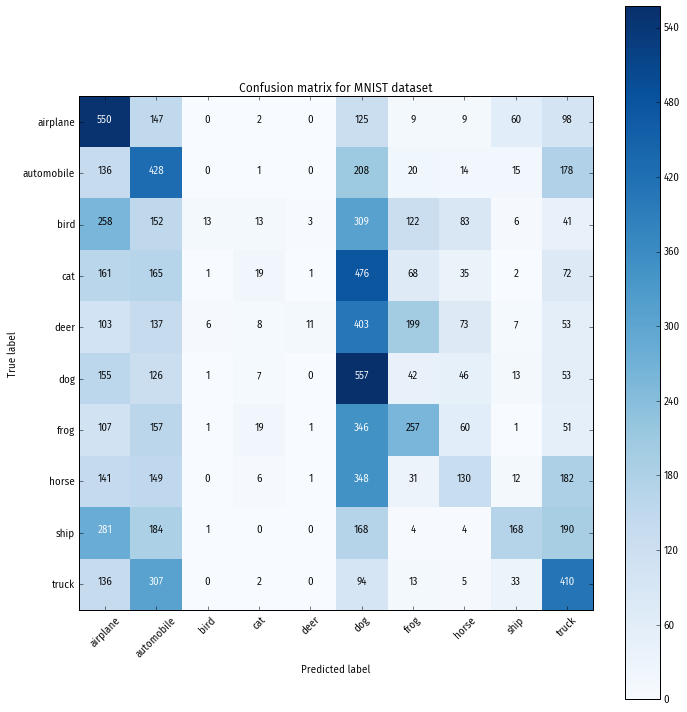

In [184]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(cifar_pred[:,0], cifar_pred[:,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=[s.decode() for s in cifar_categories],
                      title='Confusion matrix for MNIST dataset')
plt.show()

<div class='alert alert-success'>
The Naive-Bayes classifier is not very accurate on the CIFAR-10 dataset. Remarkably only dogs and airplanes are the ones that are predicted correcly most of the times. Also, the dogs class is often predicted in other classes aswell.
<br/>
At the same time, the classes *bird*, *cat* and *deer* are rarely predicted at all.
</div>

## Bayesian Linear Regression

### Code implementation

We’ll use the (Gaussian) likelihood we used for maximum likelihood

\begin{equation}
p(\mathbf{t}|\mathbf{w}, \mathbf{X}, \sigma^2) = N(\mathbf{Xw}, \sigma^2\mathbf{I})
\end{equation}

Posterior must be gaussian with unknown parameters

\begin{equation}
p(\mathbf{w}|\mathbf{X}, \mathbf{t}, \sigma^2) = N(\mathbf{\mu}, \mathbf{\Sigma})
\end{equation}

Ignoring normalising constant, the posterior is:

\begin{equation}
    p(\mathbf{w}|\mathbf{X}, \mathbf{t}, \sigma^2) \propto \exp\left\{-\frac{1}{2} (\mathbf{w^T\Sigma^{-1}w} - 2\mathbf{w^T\Sigma^{-1}\mu}) \right\}
\end{equation}

Covariance:

\begin{equation}
    \mathbf{\Sigma} = \left(\frac{1}{\sigma^2}\mathbf{X^TX} + \mathbf{S}^{-1}\right)^{-1}
\end{equation}

Mean:

\begin{equation}
    \mathbf{\mu} = \frac{1}{\sigma^2}\mathbf{\Sigma X^T t}
\end{equation}

We can compute expectation exactly, to give predictive density:

\begin{equation}
p(t_{new}|\mathbf{X}, \mathbf{t}, \mathbf{x}_{new}, \sigma^2) = N(\mathbf{x^T}_{new}\mu, \sigma^2 + \mathbf{x^T}_{new}\mathbf{\Sigma^{-1}x}_{new})
\end{equation}

In [309]:
def get_design_matrix(x, k):
    return np.array([np.array([x_i**n for n in range(k + 1)]).flatten() for x_i in np.array(x)])

def get_sigma(X, S, sigma_2):
    return np.linalg.inv(X.T.dot(X) / sigma_2 + np.linalg.inv(S))

def get_mean(X, t, Sigma, sigma_2):
    return Sigma.dot(X.T).dot(t) / sigma_2

def get_predictions(x, t, x_test, k=0, sigma_2=1):
    X = get_design_matrix(x, k)
    X_test = get_design_matrix(x_test, k)
    S = np.diag(np.random.uniform(size=X.shape[1])) # prior covariance
    Sigma = get_sigma(X, S, sigma_2)
    mu = get_mean(X, t, Sigma, sigma_2)
    
    predictions = get_limits(t, np.round(X_test.dot(mu)))
    variances = (sigma_2 + X_test.dot(np.linalg.inv(Sigma)).dot(X_test.T)).diagonal()
    return predictions, variances

def get_limits(t, predictions):
    min_t, max_t = np.min(t), np.max(t)
    predictions[predictions < min_t] = min_t
    predictions[predictions > max_t] = max_t
    return predictions

### Mnist

We use normalized data to avoid overflows and computation errors.

In [322]:
mnist_train_norm = [(label, x.flatten() / 255) for label, x in mnist_train]
mnist_test_norm = [(label, x.flatten() / 255) for label, x in mnist_test]

x = np.array([x[1].flatten() for x in mnist_train_norm])
t = np.array([x[0] for x in mnist_train_norm])
x_test = np.array([x[1].flatten() for x in mnist_test_norm])

In [323]:
predictions, variances = get_predictions(x, t, x_test, 1)
mnist_pred = np.array([(x[0], int(pred)) for x, pred in zip(mnist_test_norm, predictions)])
print('Accuracy Bayesian Linear Regression (order %d): %.2f%%' % (1, accuracy(mnist_pred) * 100))

Accuracy Bayesian Linear Regression (order 1): 23.13%


In [324]:
predictions[:10]

array([ 6.,  2.,  2.,  1.,  4.,  2.,  7.,  6.,  3.,  8.])

In [325]:
variances[:10]

array([  3.93e+10,   3.99e+10,   3.84e+10,   4.19e+10,   3.92e+10,
         3.91e+10,   3.95e+10,   3.97e+10,   4.06e+10,   4.12e+10])

In [326]:
best_accuracy = 0
best_result = ()

for order in [1, 2, 3, 4]:
    predictions, variances = get_predictions(x, t, x_test, order)
    mnist_pred = np.array([(x[0], int(pred)) for x, pred in zip(mnist_test_norm, predictions)])
    acc = accuracy(mnist_pred) * 100
    if acc > best_accuracy:
        best_accuracy = acc
        best_result = (predictions, variances)
    print('Accuracy Bayesian Linear Regression (order %d): %.2f%%' % (order, acc))

Accuracy Bayesian Linear Regression (order 1): 23.10%
Accuracy Bayesian Linear Regression (order 2): 28.26%
Accuracy Bayesian Linear Regression (order 3): 28.42%
Accuracy Bayesian Linear Regression (order 4): 28.66%


Confusion matrix, without normalization
[[333 319 195  78  28  16  10   1   0   0]
 [ 48 449 506 108  14   5   4   1   0   0]
 [ 45 121 282 298 192  64  24   5   0   1]
 [  4  30 160 319 279 131  47  24  11   5]
 [  0   1  19  69 220 326 248  80  18   1]
 [  1   4  26 123 264 273 129  45  18   9]
 [  0   4  17  60 131 283 298 136  29   0]
 [  0   0   9  32  54 146 256 280 180  71]
 [  0   1   4  18  45 117 228 290 192  79]
 [  0   0   0   7  15  37  79 248 403 220]]


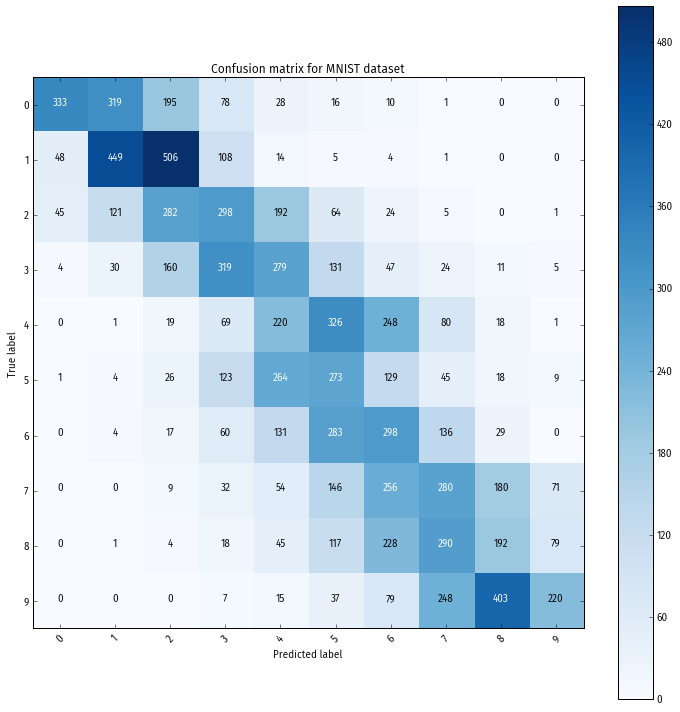

In [339]:
# Compute confusion matrix
predictions, variances = best_result
mnist_pred = np.array([(x[0], int(pred)) for x, pred in zip(mnist_test_norm, predictions)])
cnf_matrix = confusion_matrix(mnist_pred[:,0], mnist_pred[:,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=[str(i) for i in range(N)], 
                      title='Confusion matrix for MNIST dataset')
plt.show()

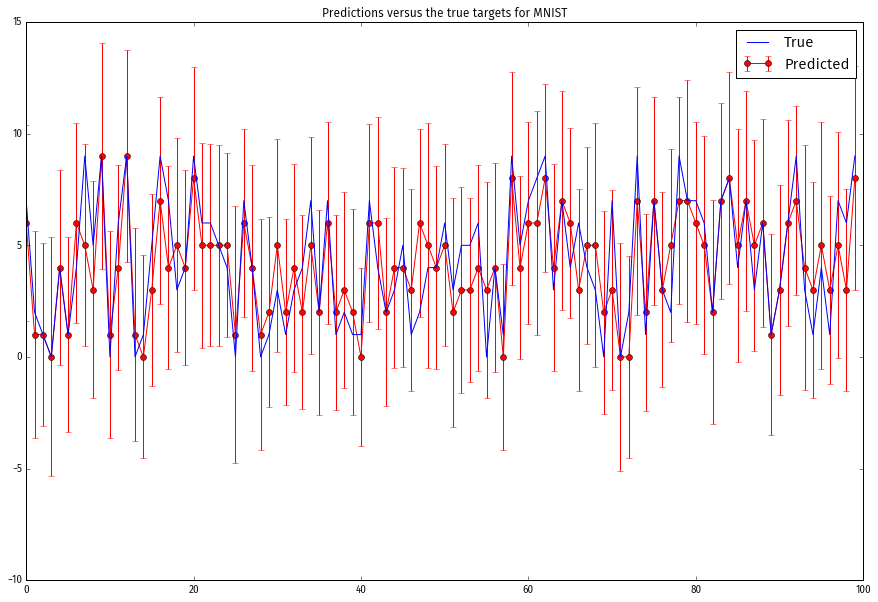

In [343]:
limit = 100
plt.figure(figsize=(15,10))
plt.title('Predictions versus the true targets for MNIST')
plt.errorbar(range(limit), mnist_pred[:,1][:limit], yerr=variances[:limit] * 1e-10, fmt='o-', label="Predicted", c='r')
plt.plot(range(limit), mnist_pred[:,0][:limit], label="True")
plt.
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={'size':15})

plt.show()

<div class='alert alert-success'>
This model is not very accurate. It is has a lot of uncertainty around the prediction as we can see from the plot above. The error lines (which have been scaled down by an order of $1 \cdot 10^{-10}$) highlights the uncertainity around the prediction very well.
</div>

### CIFAR-10

In [329]:
cifar_train_norm = [(label, x / 255) for label, x in zip(cifar_data_1[b'labels'], cifar_data_1[b'data'])]
cifar_test_norm = [(label, x / 255) for label, x in zip(cifar_test_data[b'labels'], cifar_test_data[b'data'])]

x = np.array([x[1] for x in cifar_train_norm])
t = np.array([x[0] for x in cifar_train_norm])
x_test = np.array([x[1] for x in cifar_test_norm])

In [332]:
predictions, variances = get_predictions(x, t, x_test, 1)

In [333]:
cifar_pred = np.array([(int(pred), x[0]) for x, pred in zip(cifar_test_norm, predictions)])

In [334]:
print('Accuracy Bayesian Linear Regression: %.2f%%' % (accuracy(cifar_pred) * 100))

Accuracy Bayesian Linear Regression: 11.00%


Confusion matrix, without normalization
[[  4   8   0   5   0   4   2   6   1   3]
 [ 13  24  14  12  13  15  16  21   6   4]
 [ 71  59  45  43  43  55  50  37  18  22]
 [227 171 192 174 171 178 139 128 109 102]
 [323 262 345 315 348 364 266 218 281 215]
 [223 232 270 289 288 245 302 276 338 261]
 [ 88 150 102 121 104  98 150 189 158 215]
 [ 36  66  25  36  27  29  59  76  68 107]
 [  7  18   5   3   6  11  13  40  18  55]
 [  8  10   2   2   0   1   3   9   3  16]]


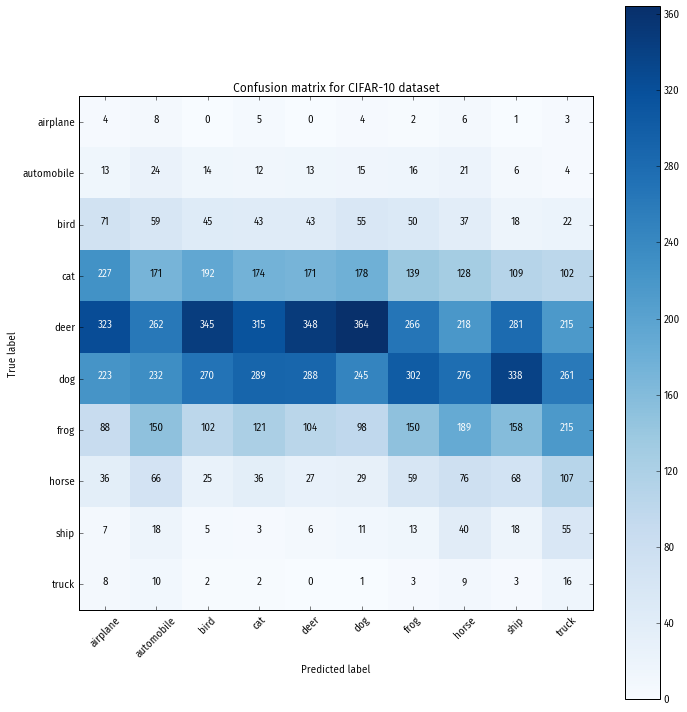

In [338]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(cifar_pred[:,0], cifar_pred[:,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=[s.decode() for s in cifar_categories],
                      title='Confusion matrix for CIFAR-10 dataset')
plt.show()

<div class='alert alert-success'>
As we can see, the most correct prediction comes from *deer*, but we cannot really use this model to predict figures, since its accuracy is almost as good as a random predictor!
<br>
Due to memory limitations, we cannot experiment with further higher level of interpolation, by increasing the order of the design matrix.
</div>